In [ ]:
!pip install prophet --no-binary :all:

In [ ]:
import pandas as pd
import numpy as np
import prophet
import matplotlib.pyplot as plt
import pandas_datareader as web
import warnings


In [ ]:
data = pd.read_csv('/content/google_historical_data.csv')
data.sort_values(by='Date', inplace=True)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1378,2023-07-14,124.800003,126.779999,123.489998,125.419998,125.419998,33266800
1379,2023-07-17,125.940002,127.099998,124.199997,124.650002,124.650002,25716200
1380,2023-07-18,124.599998,124.680000,122.959999,123.760002,123.760002,26226400
1381,2023-07-19,124.599998,125.180000,121.800003,122.029999,122.029999,37224000
1382,2023-07-20,121.419998,124.089996,118.220001,119.199997,119.199997,37906800


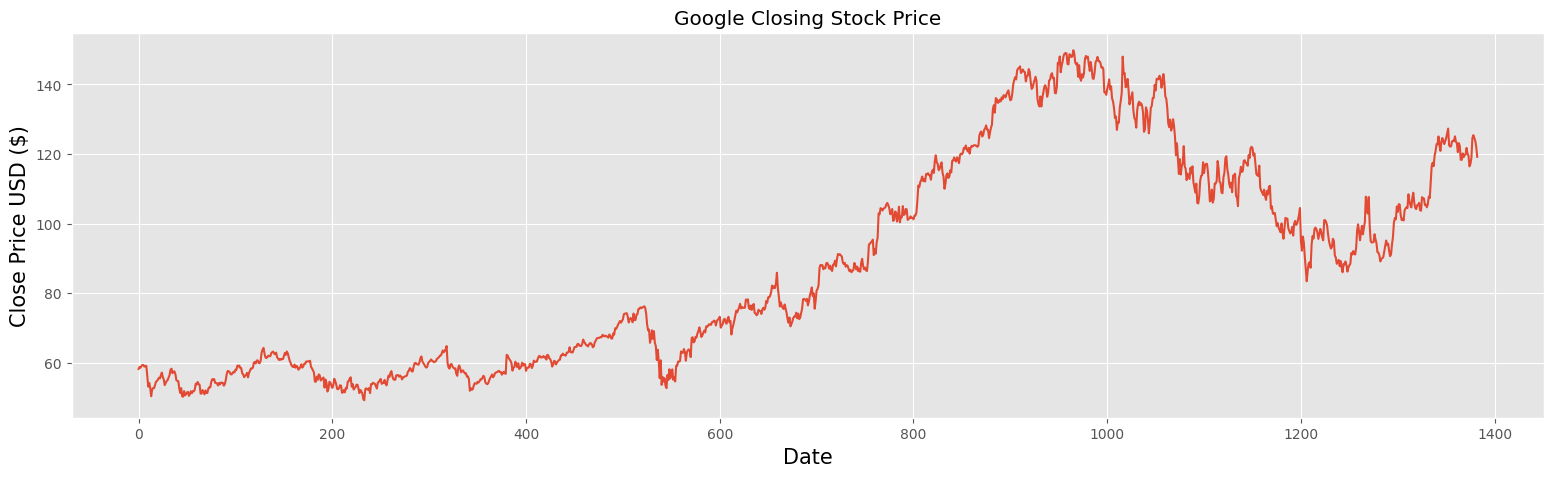

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(19,5))
plt.title("Google Closing Stock Price")
plt.plot(data["Close"])
plt.xlabel("Date", c = 'black', fontsize=15)
plt.ylabel("Close Price USD ($)", c = 'black', fontsize=15)
plt.show()

In [ ]:
df = pd.DataFrame()
df['ds'] = pd.to_datetime(data['Date'])
df['y'] = data['Close']
df.head()

,ds,y
0,2018-01-22,58.208000
1,2018-01-23,58.808498
2,2018-01-24,58.564499
3,2018-01-25,59.106998
4,2018-01-26,59.377998


In [ ]:
# Split ratio of 80% for training, 20% for testing
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split index based on the chosen ratio
split_index = int(train_ratio * len(df))

# Split the data into training and test sets
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]
train_df.tail()

,ds,y
1101,2022-06-06,116.820503
1102,2022-06-07,117.149498
1103,2022-06-08,117.194000
1104,2022-06-09,114.835503
1105,2022-06-10,111.161499


In [ ]:
from prophet.forecaster import Prophet
model = Prophet(daily_seasonality=True)
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp17j9sw9r/cknl7vh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp17j9sw9r/16sykshm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19745', 'data', 'file=/tmp/tmp17j9sw9r/cknl7vh5.json', 'init=/tmp/tmp17j9sw9r/16sykshm.json', 'output', 'file=/tmp/tmp17j9sw9r/prophet_modelgo3s5szf/prophet_model-20230722084407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# predicting for the test data
future_dates = test_df[['ds']]
predictions = model.predict(future_dates)
predictions[['ds', 'yhat', 'yhat_lower',
          'yhat_upper', 'trend',
          'trend_lower', 'trend_upper']].head()




,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2022-06-13,121.232088,116.055327,126.637020,132.836933,132.836933,132.836933
1,2022-06-14,121.268564,116.208523,126.466293,132.795852,132.795852,132.795852
2,2022-06-15,121.443283,116.303668,126.725161,132.754770,132.754770,132.754770
3,2022-06-16,121.393287,116.166918,126.589472,132.713688,132.713688,132.713688
4,2022-06-17,121.252419,116.446776,126.420809,132.672607,132.672607,132.672607


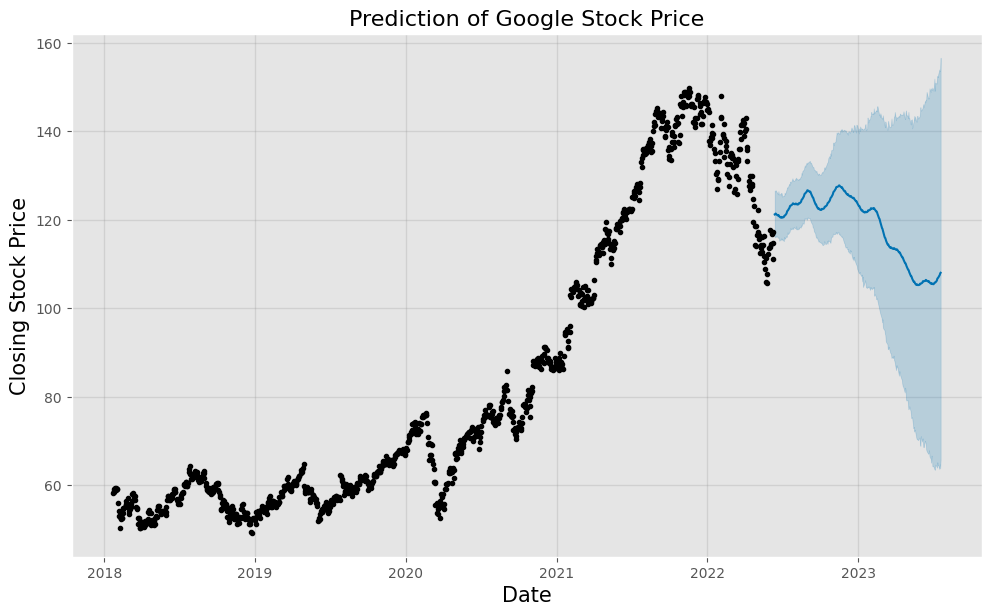

In [ ]:
model.plot(predictions)
plt.style.use("fivethirtyeight")
plt.title("Prediction of Google Stock Price", fontsize = 16)
plt.xlabel("Date", c = 'black', fontsize = 15)
plt.ylabel("Closing Stock Price", c = 'black', fontsize = 15)
plt.show()

#### The above image shows the basic prediction. The light blue is the uncertainty level(yhat_upper and yhat_lower), the dark blue is the prediction(yhat) and the black dots are the original data.

In [ ]:
predicted_values = predictions['yhat'].values
predicted_values

In [ ]:
from sklearn.metrics import mean_squared_error

# Get the actual values from the test set
y_true = test_df['y'].values

# Get the predicted values
y_pred = predicted_values

# Calculating the RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(predictions['yhat'].head())
print(test_df['y'].head())


Root Mean Squared Error (RMSE): 21.251689767585574
0    121.232088
1    121.268564
2    121.443283
3    121.393287
4    121.252419
Name: yhat, dtype: float64
1106    106.392502
1107    106.715500
1108    109.764503
1109    106.033501
1110    107.143501
Name: y, dtype: float64


The RMSE value of 21.25 means that, on average, the predicted stock prices deviate from the actual stock prices by approximately 21.25 units. The smaller the RMSE, the better the model's performance because it means the predicted values are closer to the actual values.

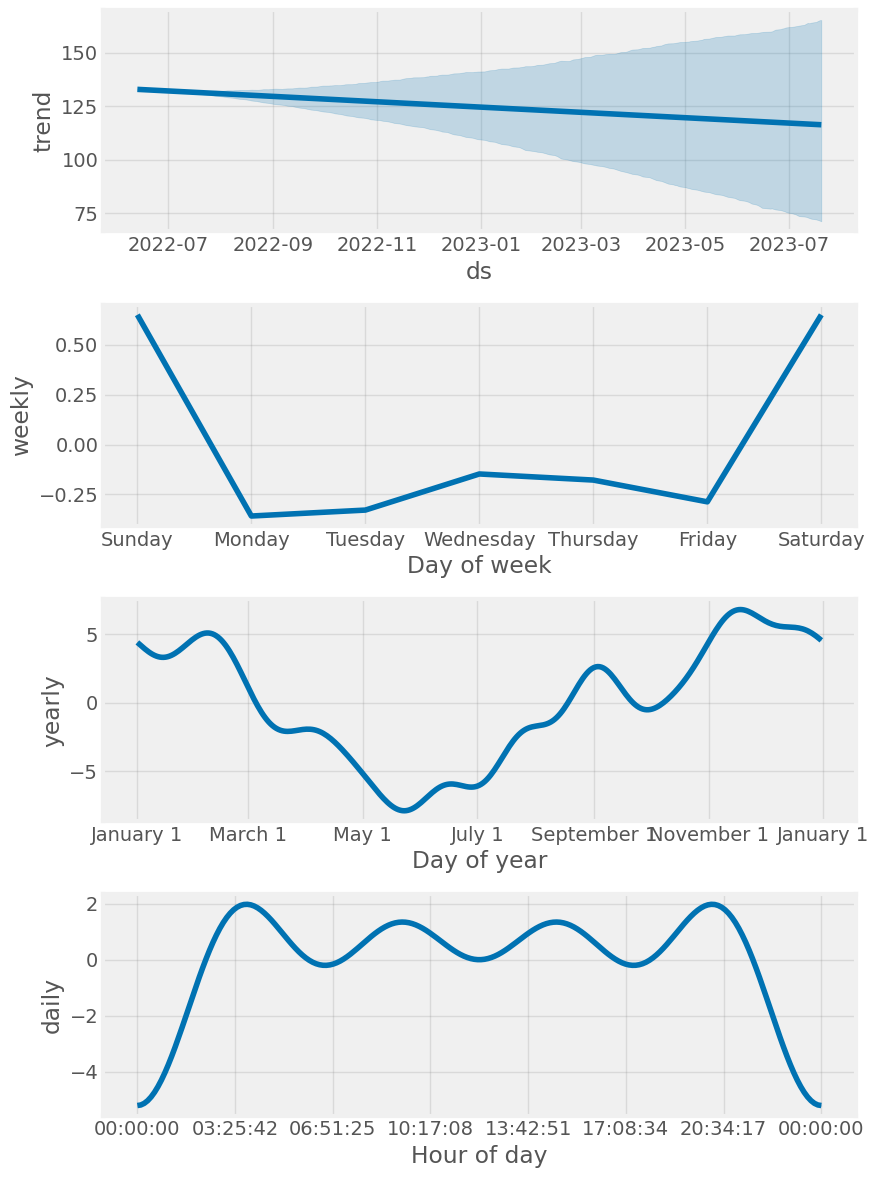

In [ ]:
model.plot_components(predictions)
plt.show()

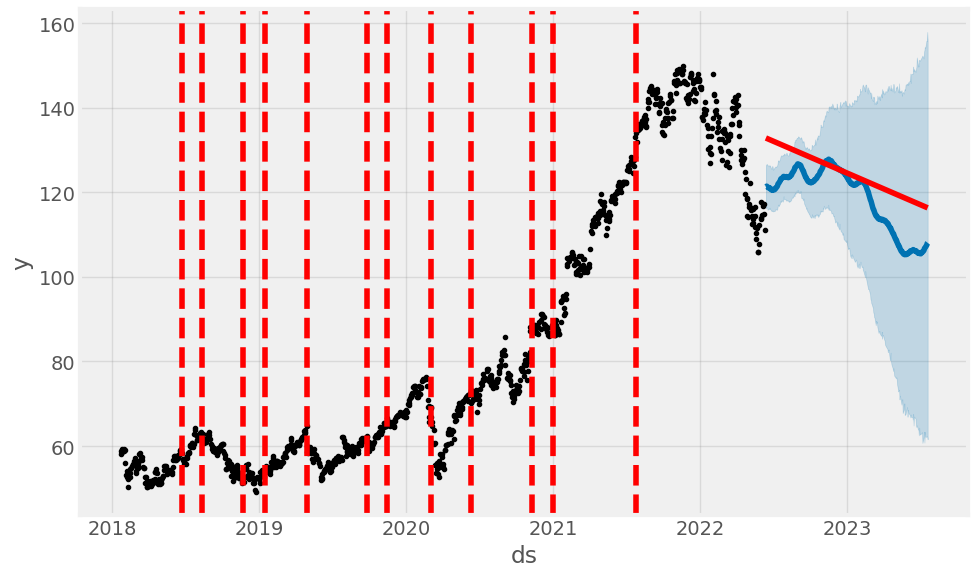

In [ ]:
from prophet.plot import add_changepoints_to_plot
# Add changepoints to indicate the time in rapid trend growths. The dotted red lines show the time when there was a rapid change in the trend
fig = model.plot(predictions)
a = add_changepoints_to_plot(fig.gca(),
                             model, predictions)

## Trying time series cross validation

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/cxce3ry5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/gd68213i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55162', 'data', 'file=/tmp/tmp5pwwa9k6/cxce3ry5.json', 'init=/tmp/tmp5pwwa9k6/gd68213i.json', 'output', 'file=/tmp/tmp5pwwa9k6/prophet_model21vnn9_h/prophet_model-20230724102221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


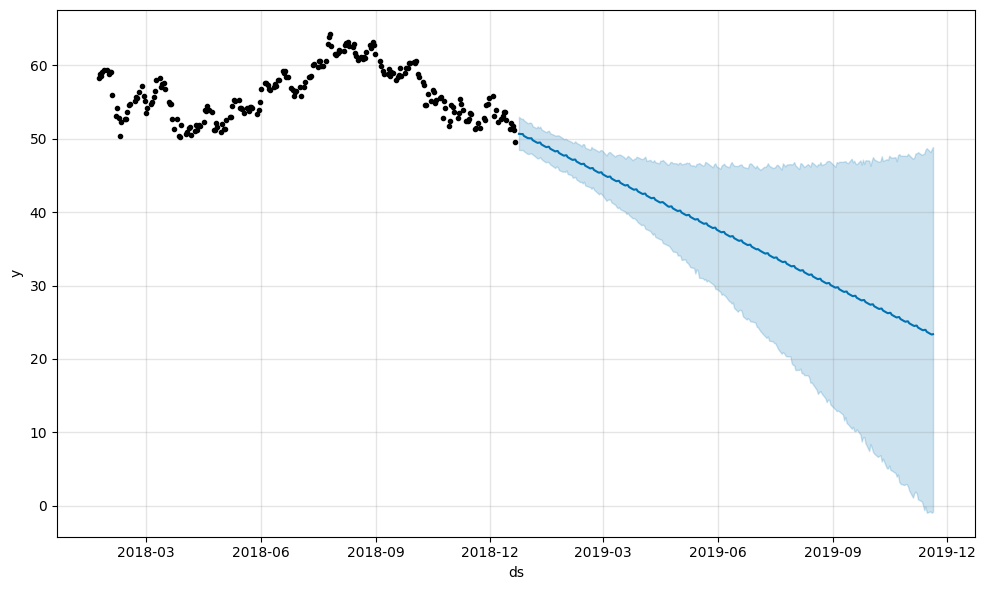

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/dj91zmra.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/ukol2won.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38277', 'data', 'file=/tmp/tmp5pwwa9k6/dj91zmra.json', 'init=/tmp/tmp5pwwa9k6/ukol2won.json', 'output', 'file=/tmp/tmp5pwwa9k6/prophet_modelkgjkjyl0/prophet_model-20230724102222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


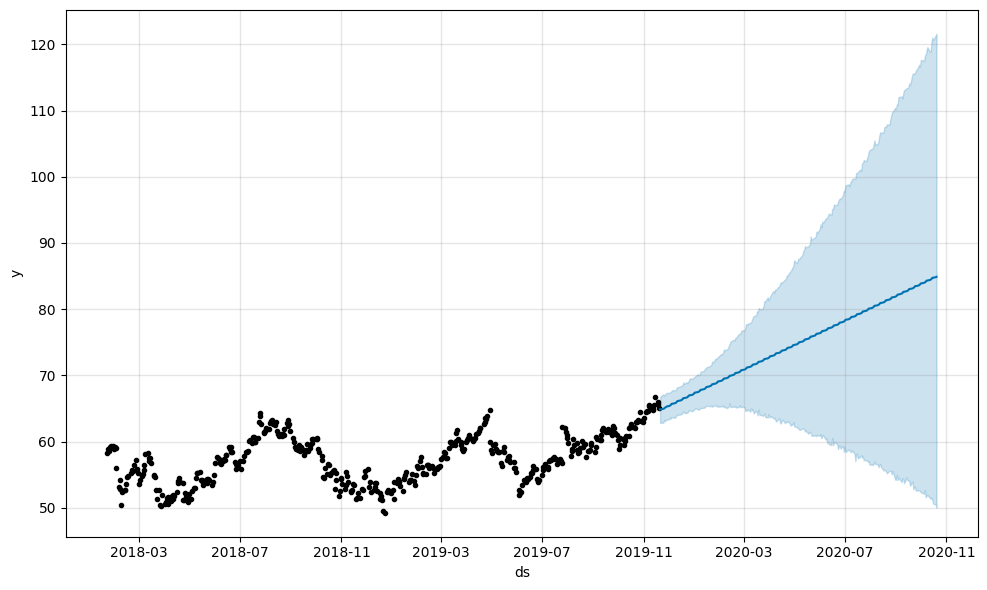

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/mwkcr1bo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/jejgx98w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47932', 'data', 'file=/tmp/tmp5pwwa9k6/mwkcr1bo.json', 'init=/tmp/tmp5pwwa9k6/jejgx98w.json', 'output', 'file=/tmp/tmp5pwwa9k6/prophet_model742twpke/prophet_model-20230724102222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


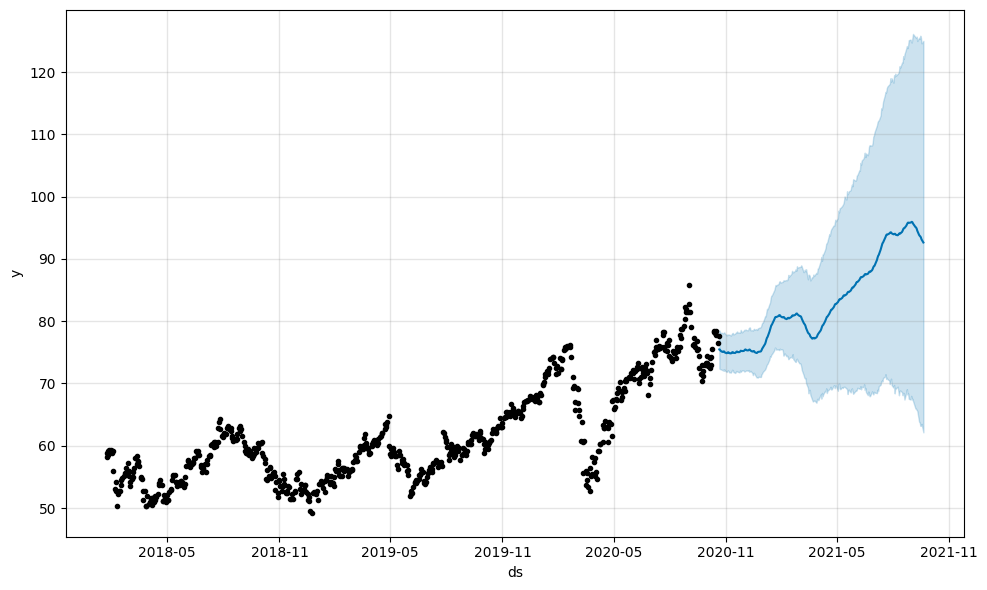

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/gj0hvfjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/zo8olwec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9833', 'data', 'file=/tmp/tmp5pwwa9k6/gj0hvfjz.json', 'init=/tmp/tmp5pwwa9k6/zo8olwec.json', 'output', 'file=/tmp/tmp5pwwa9k6/prophet_model7dgv7tle/prophet_model-20230724102223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


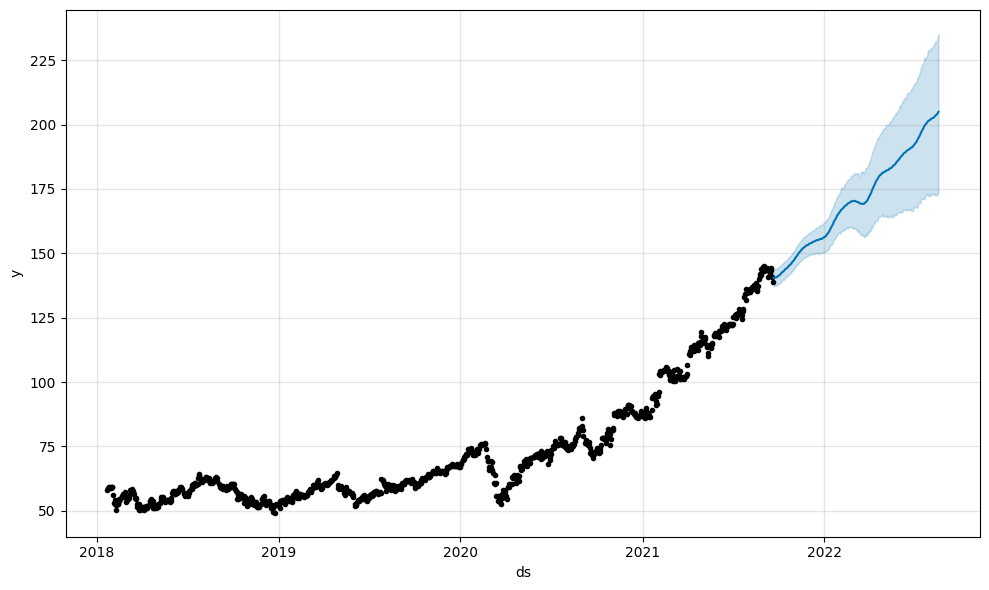

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/kf5bjg0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5pwwa9k6/9p1cvouf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9865', 'data', 'file=/tmp/tmp5pwwa9k6/kf5bjg0k.json', 'init=/tmp/tmp5pwwa9k6/9p1cvouf.json', 'output', 'file=/tmp/tmp5pwwa9k6/prophet_modelrw5mqack/prophet_model-20230724102224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


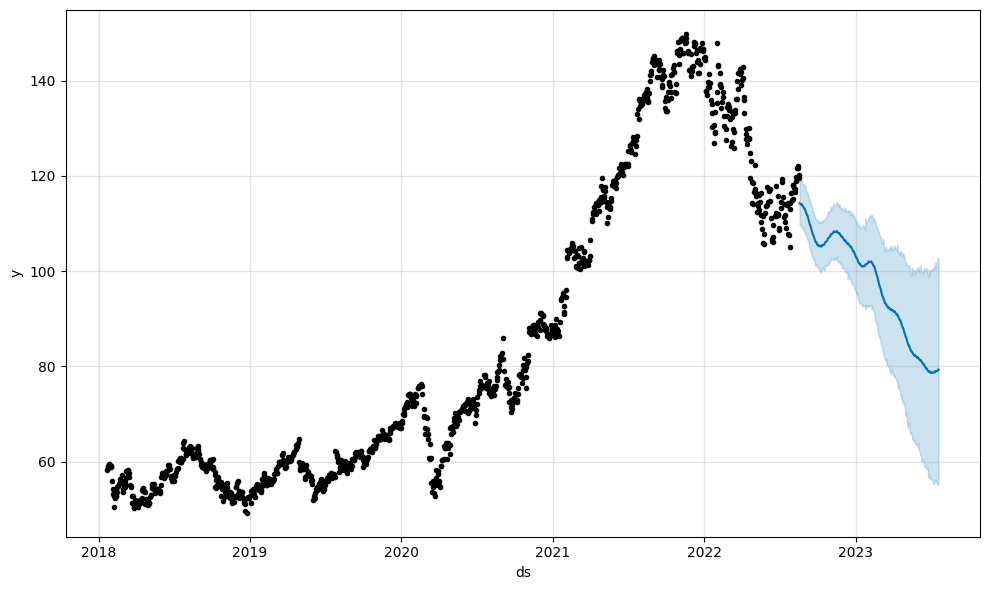

Average MSE across folds: 907.1113288476148


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Load the CSV data into a pandas DataFrame
data = pd.read_csv('/content/google_historical_data.csv')

df = pd.DataFrame()
df['ds'] = pd.to_datetime(data['Date'])
df['y'] = data['Close']

# Convert the date column to datetime format (skip this step if it's already in datetime format)


# Sort the DataFrame by date in ascending order
df.sort_values(by='ds', inplace=True)

# Define the number of splits (folds) you want to create
n_splits = 5

# Create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize an array to store the Mean Squared Error (MSE) for each fold
fold_mses = []

# Iterate over the splits and train/test the model
for train_index, test_index in tscv.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # Initialize the Prophet model
    model = Prophet()

    # Fit the model to the training data
    model.fit(train_df)

    # Create a DataFrame with future dates for forecasting (use the test dataset here)
    future_dates = test_df[['ds']].copy()
    # future_dates.rename(columns={'date': 'ds'}, inplace=True)  # Rename the date column to 'ds'

    # Generate forecasts for the future dates (test dataset)
    forecast = model.predict(future_dates)

    # Get the actual values from the test set
    y_true = test_df['y'].values

    # Get the forecasted values from the forecast DataFrame
    y_pred = forecast['yhat'].values

    # Calculate the MSE for the fold
    mse = mean_squared_error(y_true, y_pred)
    fold_mses.append(mse)

    # Optionally, you can plot the forecasted stock prices for each fold
    model.plot(forecast)
    plt.show()

# Calculate and print the average and overall evaluation metrics across all folds
average_mse = np.mean(fold_mses)
print(f"Average MSE across folds: {average_mse}")
